# Smart Plan data mining (Service Time)

## Outline
- [1 - Business Understanding](#1)
- [2 - Data Understanding](#2)
  - [2.1 - Initial Data Collection](#2.1)
  - [2.2 - Data Description](#2.2)
  - [2.3 - Data Exploration](#2.3)
- [3 - Data Preparation](#3)
  - [3.1 - Data Cleaning](#3.1)
    - [3.1.1 - Missing Values](#3.1.1)
    - [3.1.2 - Outliers](#3.1.2)
  - [3.2 - Data Transformation](#3.2)
    - [3.2.1 - Feature engeenering](#3.2.1)
    - [3.2.2 - Data Standardization](#3.2.2)
- [4 - Modeling](#4)
  - [4.1 - Serie Temporelle](#4.1)
    - [4.1.1 - LSTM](#4.1.1)
    - [4.1.2 - SARIMA](#4.1.2)
  - [4.2 - Neural Networks](#4.2)    
  - [4.3 - Random Forest](#4.3)
- [5 - Evaluation](#5)


<a name="1"></a>
## 1 - Business Understanding
### Important Assumptions

In this analysis, we base our exploration on some assumptions in order to can predict service time :

- **Units of Time**: The units for `dta`, `dts`, and `dtc`, as defined in the article by Feyman et al. 2021, are "days to approved," "days to scheduled," and "days to completed." However, in this dataset, the units are not likely to be days. Given the ambulatory nature of the clinics involved, it is improbable that these durations exceed 24 hours. So we assume therefore these measurements are expressed in **hours** or **minutes**.
    - If these durations were measured in days, we would expect the decimal part of these values (i.e., parts of a day) to be significant, and the differences between `dtc` and `dts` for each activity to generally be less than 1. However, our dataset does not consistently support this scenario.
    - Further analysis will allow us to corroborate or refute this hypothesis.

- **Simplifying Assumptions for the Analysis**:
    - We assume that patients and staff are punctual, meaning that the scheduled time (`dts`) closely matches the actual start time of the consultation.
    - There are no interruptions or delays during the consultation process that significantly alter the duration between the scheduled time and the end time (`dtc`).
![Variables Description](./images/time.png)

<a name="1"></a>
## 1.1 Business Objectives
- Minimize the average waiting time and the average idle time in outpatient clinic

## 1.2 Current Situation
- Discussion of current scheduling procedures.

## 1.3 Data Mining Goals
-  Predict the service time

<a name="2"></a>
## 2 - Data Understanding

## 2.1 - Initial Data Collection<a name="2.1"></a>

In [1]:
#Load our local fonctions
from utils_st import *
# load librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Genera setting
path_data = "data/consult_waits_2024_03_25.csv"

In the following code block, we are loading data using `pandas.read_csv` with a predefined list of columns and specified data types for each column. This approach helps optimize memory usage by ensuring that each column is stored in the most memory-efficient format suitable for its data type.

- **Columns to Load**: We specify the columns to be loaded to avoid unnecessary memory usage by excluding irrelevant data. The `dto` variable is excluded because it's the sum of `dta` and `dtc`. Additionally, `year` and `month` were not loaded as they are sub-parts of the `activitydatetime` column. 
- **Data Types**: Specifying data types explicitly (`dtype`) helps in several ways:
- **Error Handling**: We include error handling during the load process to catch issues that might occur if the data does not conform to the expected format or if there are issues reading the file. This can help in debugging and ensuring data quality.

![Variables Description](./images/variables_description.PNG)
*Variables Description of raw data*


In [3]:
# List of column to load
cols_to_use = ['patientsid', 'activitydatetime', 'sta3n', 'stopcode',
               'dta', 'dts', 'dtc', 'non_va', 'zip', 'state', 'disp', 'AdministrativeFlag']

data_types = {
    'patientsid': 'uint32',
    'sta3n': 'category',
    'stopcode': 'category',
    'dta': 'float32',
    'dts': 'float32',
    'dtc': 'float32',
    'non_va': 'category',
    'zip': 'category',
    'state': 'category',
    'disp': 'category',
    'AdministrativeFlag': 'category'
}
# Pour capturer les éventuelles erreurs de chargement et les traiter
try:
    data = pd.read_csv(path_data, dtype=data_types, usecols=cols_to_use)
except Exception as e:
    print("Une erreur est survenue lors de la lecture du fichier CSV:", e)

<a name="2.2"></a>
### 2.2 - Data description

In [6]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51874107 entries, 0 to 51874106
Data columns (total 12 columns):
 #   Column              Dtype   
---  ------              -----   
 0   patientsid          uint32  
 1   activitydatetime    object  
 2   sta3n               category
 3   stopcode            category
 4   dta                 float32 
 5   dts                 float32 
 6   dtc                 float32 
 7   non_va              category
 8   zip                 category
 9   state               category
 10  disp                category
 11  AdministrativeFlag  category
dtypes: category(7), float32(3), object(1), uint32(1)
memory usage: 4.9 GB


In [8]:
data.shape

(51874107, 12)

In [42]:
data.head()

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,dtc,non_va,zip,state,disp,AdministrativeFlag
0,9204541,2023-06-15 14:43:56,573,354,5.0,3,0,1,315,GEORGIA,COMPLETE/UPDATE,Y
1,9204541,2017-02-01 10:20:10,573,403,0.0,30,64,0,315,GEORGIA,COMPLETE/UPDATE,NaN
2,9204541,2021-11-03 09:32:28,573,407,2.0,54,48,1,315,GEORGIA,COMPLETE/UPDATE,Y
3,9204541,2015-03-26 14:30:45,573,408,1.0,134,149,0,315,GEORGIA,COMPLETE/UPDATE,NaN
4,9204541,2019-02-08 12:41:00,573,409,0.0,28,44,0,315,GEORGIA,COMPLETE/UPDATE,NaN


*Numeric Data Summary*:

In [43]:
data.describe()

,patientsid,dta,dts,dtc
count,5.187411e+07,5.187411e+07,5.187411e+07,5.187411e+07
mean,4.984383e+08,2.999573e+00,1.702317e+01,3.565647e+01
std,5.770953e+08,1.062987e+01,3.019874e+01,3.668677e+01
min,1.306000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.353260e+07,0.000000e+00,1.000000e+00,1.300000e+01
50%,2.602300e+07,1.000000e+00,6.000000e+00,2.600000e+01
75%,1.007936e+09,2.000000e+00,2.000000e+01,4.600000e+01
max,1.605574e+09,3.650000e+02,1.367000e+03,3.650000e+02


*Categorical Data Summary*:

In [8]:
categorical = data.dtypes[data.dtypes == "category"].index
print(categorical)
data[categorical].describe()

Index(['sta3n', 'stopcode', 'non_va', 'zip', 'state', 'disp',
       'AdministrativeFlag'],
      dtype='object')


,sta3n,stopcode,non_va,zip,state,disp,AdministrativeFlag
count,51874107,51874107,51874107,51873257,51874107,51874107,20182672
unique,130,365,2,921,67,4,3
top,589,205,0,782,FLORIDA,COMPLETE/UPDATE,Y
freq,1066491,2870638,36757317,520511,4708517,49443083,16487037


In [9]:
data['disp'].unique()

['COMPLETE/UPDATE', 'DISCONTINUED', 'CANCELLED', 'EU']
Categories (4, object): ['CANCELLED', 'COMPLETE/UPDATE', 'DISCONTINUED', 'EU']

In [10]:
data["stopcode"].unique()

['354', '403', '407', '408', '409', ..., '136', '715', '168', '670', '447']
Length: 365
Categories (365, object): ['102', '103', '104', '105', ..., '715', '168', '670', '447']

In [11]:
data["sta3n"].unique()

['573', '508', '568', '570', '659', ..., '515', '630', '526', '358', '620']
Length: 130
Categories (130, object): ['358', '402', '405', '436', ..., '695', '740', '756', '757']

<a id="2.3"></a>
### 2.3 - Data Exploration

Explore the data to uncover patterns, relationships, and potential anomalies. This step includes visualizing distributions of numeric and categorical data and examining relationships between variables.

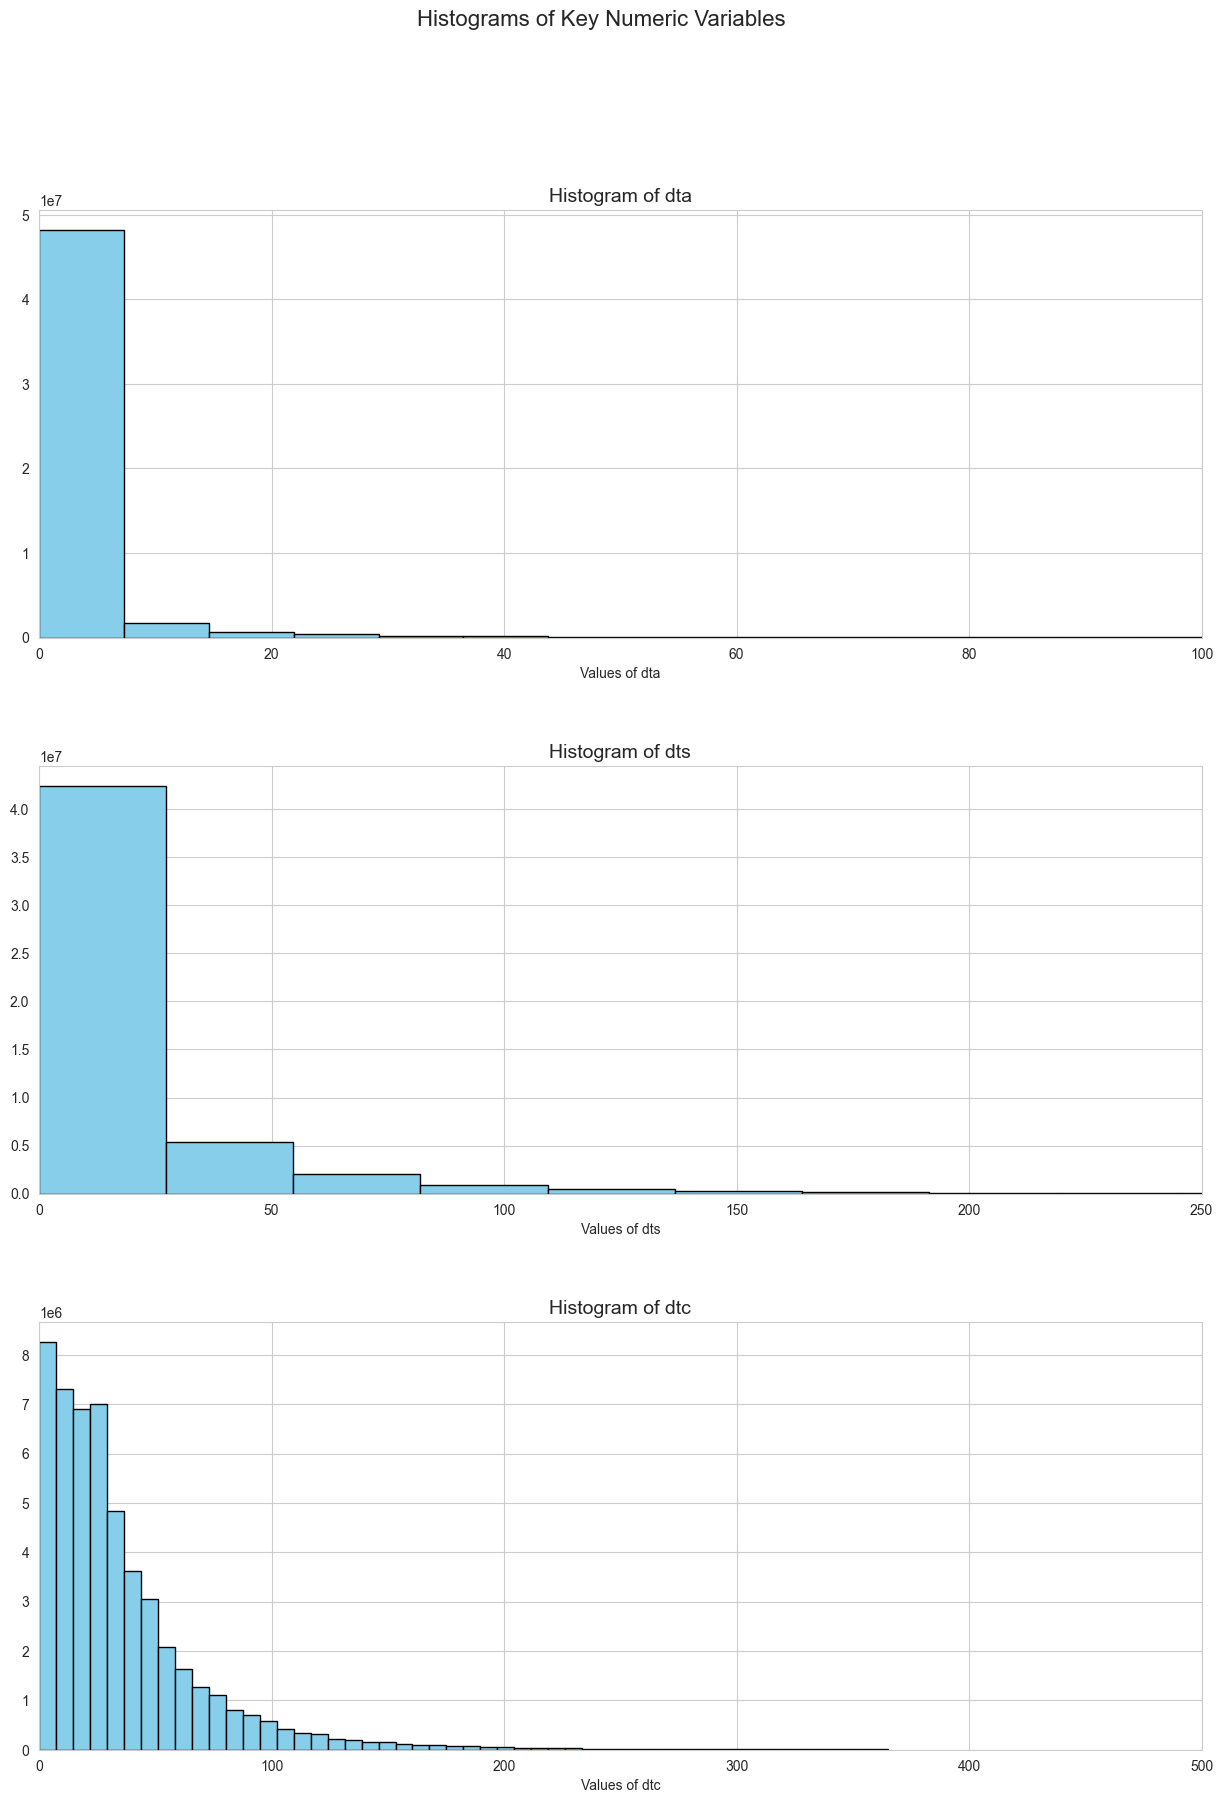

In [17]:
plot_histograms_numeric(data)

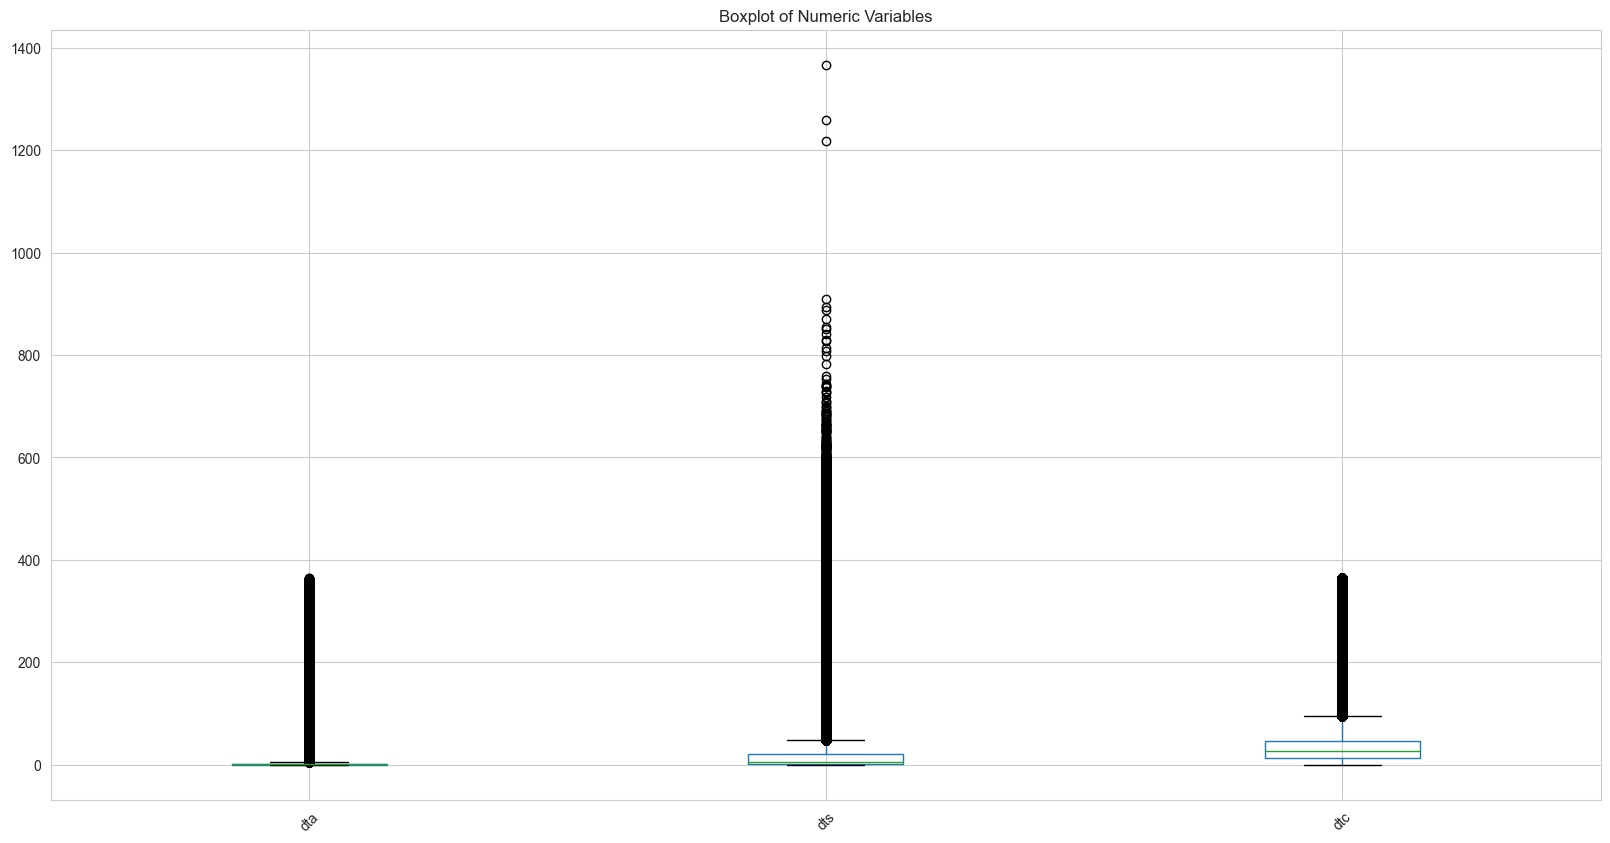

In [13]:
## Boxplots for numeric variables to spot outliers
fig, ax = plt.subplots(figsize=(20, 10))
data[["dta", "dts", "dtc", "non_va"]].boxplot(ax=ax)
plt.title('Boxplot of Numeric Variables')
plt.xticks(rotation=45)
plt.show()

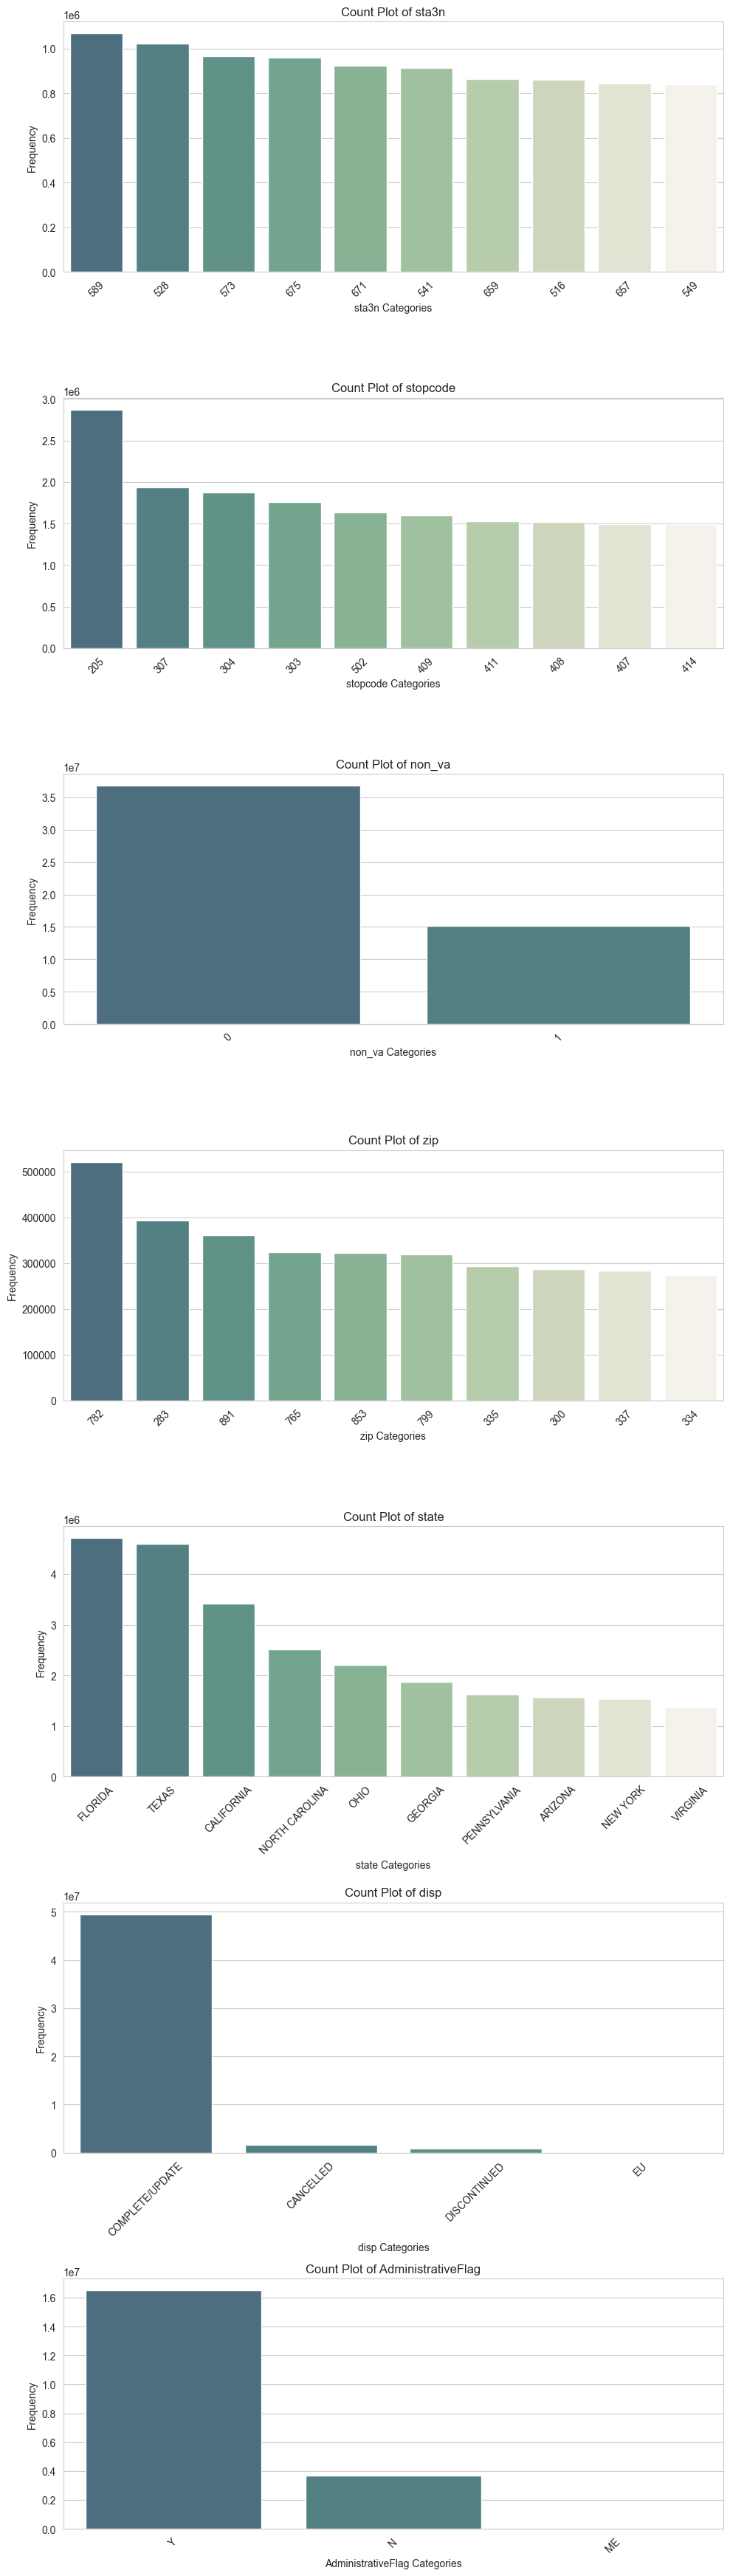

In [5]:
plot_top_category_counts(data)

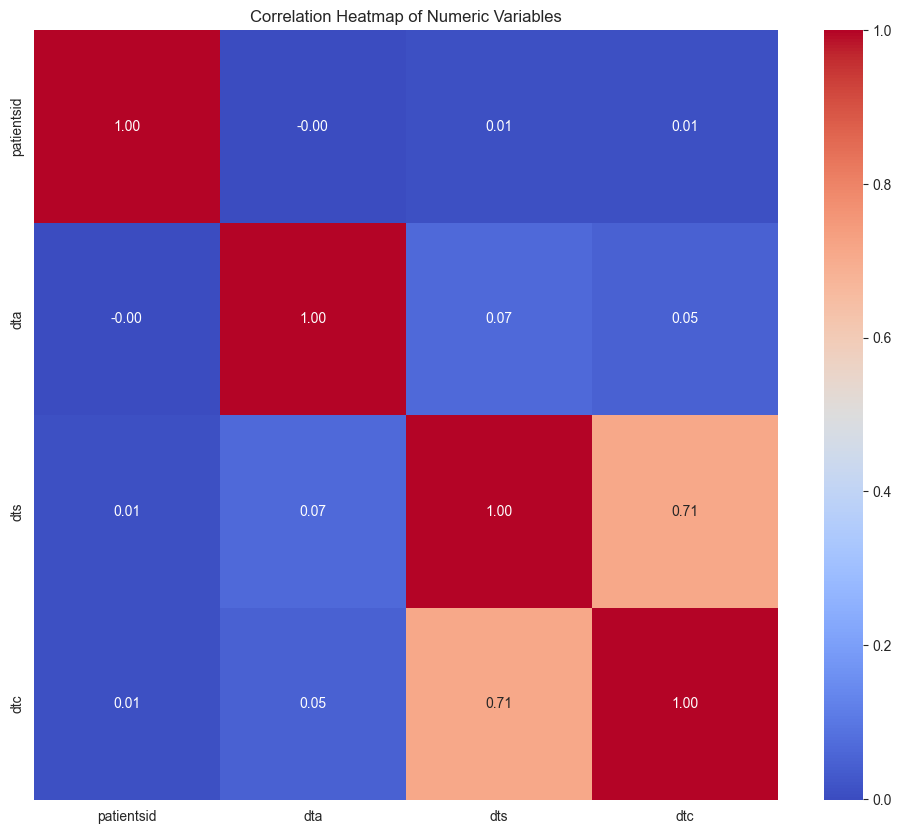

In [6]:
## Correlation Heatmap of Numeric Variables
plt.figure(figsize=(12, 10))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

Corélation entre dts et dtc qui corobore bien notre choix de résumer ces deux information en une seule, le temps de service

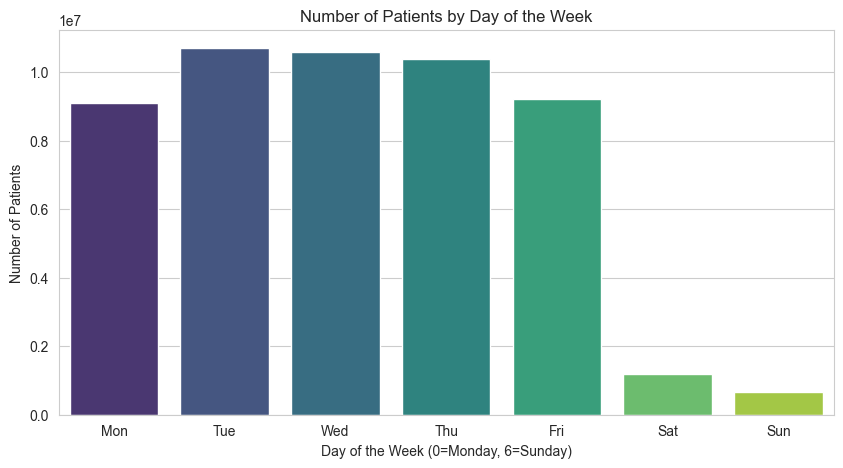

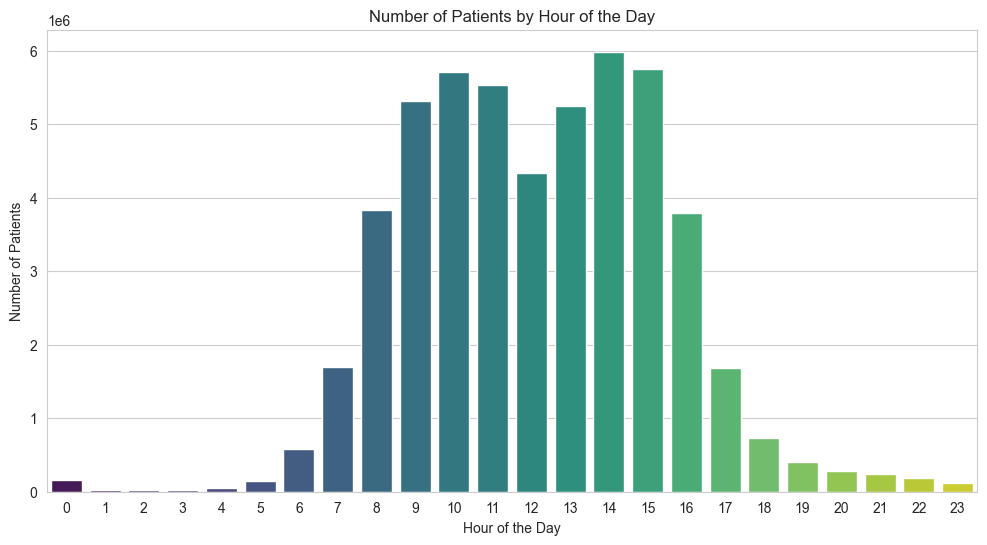

In [19]:
analyze_working_patterns(data)

## 3 - Data Preparation<a name="3"></a>
### 3.1 - Data Cleaning<a name="3.1"></a>

3.1.1 - Missing Values<a name="3.1.1"></a>

Missing Values Count Per Column:
patientsid                   0
activitydatetime             0
sta3n                        0
stopcode                     0
dta                          0
dts                          0
dtc                          0
non_va                       0
zip                        850
state                      628
disp                         0
AdministrativeFlag    31691435
dtype: int64

Missing Values Percentage Per Column:
zip                    0.001639
state                  0.001211
AdministrativeFlag    61.092975
dtype: float64


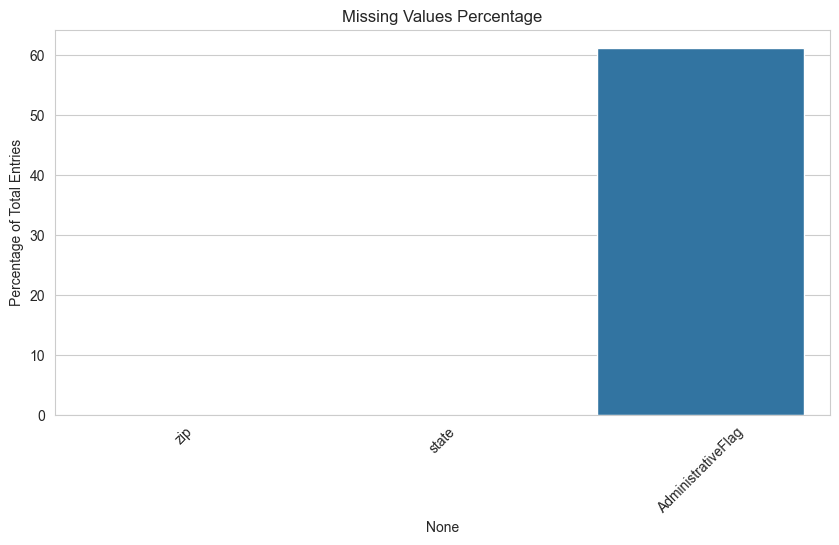

In [7]:
display_missing_values(data)

In [8]:
data[data['zip'].isnull()].head()

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,dtc,non_va,zip,state,disp,AdministrativeFlag
132087,24261,2015-06-15 11:54:58,358,423,0.0,0,0,0,NaN,*Missing*,COMPLETE/UPDATE,Y
132105,27765,2015-02-20 16:43:23,358,423,0.0,0,0,0,NaN,*Missing*,COMPLETE/UPDATE,Y
375782,1602406208,2022-09-16 21:09:17,663,323,1.0,13,72,1,NaN,*Missing*,COMPLETE/UPDATE,Y
426598,801540320,2016-04-04 13:54:34,691,104,7.0,0,7,0,NaN,*Missing*,COMPLETE/UPDATE,N
962087,800924574,2016-05-15 09:56:05,691,104,0.0,1,34,0,NaN,CALIFORNIA,COMPLETE/UPDATE,N


In [9]:
# Filter rows where 'AdministrativeFlag' is null and display the last 10 rows
data[data['AdministrativeFlag'].isnull()].tail(5)

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,dtc,non_va,zip,state,disp,AdministrativeFlag
51874089,7941828,2023-05-15 09:15:35,557,414,35.0,0,7,0,312,GEORGIA,CANCELLED,NaN
51874095,7949492,2022-05-16 10:58:36,557,303,0.0,10,15,0,310,GEORGIA,COMPLETE/UPDATE,NaN
51874096,7949492,2014-10-01 13:14:59,557,307,3.0,35,44,0,310,GEORGIA,COMPLETE/UPDATE,NaN
51874097,7949492,2022-01-25 12:43:47,557,338,3.0,65,65,0,310,GEORGIA,COMPLETE/UPDATE,NaN
51874102,7949492,2022-09-28 11:07:20,557,414,0.0,12,21,0,310,GEORGIA,COMPLETE/UPDATE,NaN


In [10]:
# directly using the condition within the crosstab function, avoiding creating a new column.
cross_tab = pd.crosstab(index=data['non_va'], columns=data['AdministrativeFlag'].isnull(), rownames=['non_va'], colnames=['AdminFlag Missing'])

# Rename columns for better readability
cross_tab.columns = ['AdminFlag Not Missing', 'AdminFlag Missing']

cross_tab


,AdminFlag Not Missing,AdminFlag Missing
non_va,,
0,5235920,31521397
1,14946752,170038


Given the high volume of missing data and its MAR (Missing at Random) nature, and we assume AdministrativeFlag is not critical to analysis, considering its removal could streamline the dataset and focus efforts on more reliable variables.

*Missing value prepocessing*

In [4]:
data.drop('AdministrativeFlag', axis=1, inplace=True)

In [5]:
# Identifier les indices des lignes où 'zip' est NaN ou 'state' est '*Missing*'
missing_zip_index = data[data['zip'].isnull()].index
missing_state_index = data[data['state'] == '*Missing*'].index

# Combinez les indices dans un seul ensemble pour assurer l'unicité
all_missing_indices = missing_zip_index.union(missing_state_index)

# Supprimer les lignes avec des indices combinés en une seule opération
data.drop(index=all_missing_indices, inplace=True)

In [6]:
print(data.shape)

(51873257, 11)


3.1.2 - Outliers<a name="3.1.2"></a>

Outliers (IQR) Count Per Numeric Column:
{'patientsid': 0, 'dta': 5461500, 'dts': 4798986, 'dtc': 3220423}


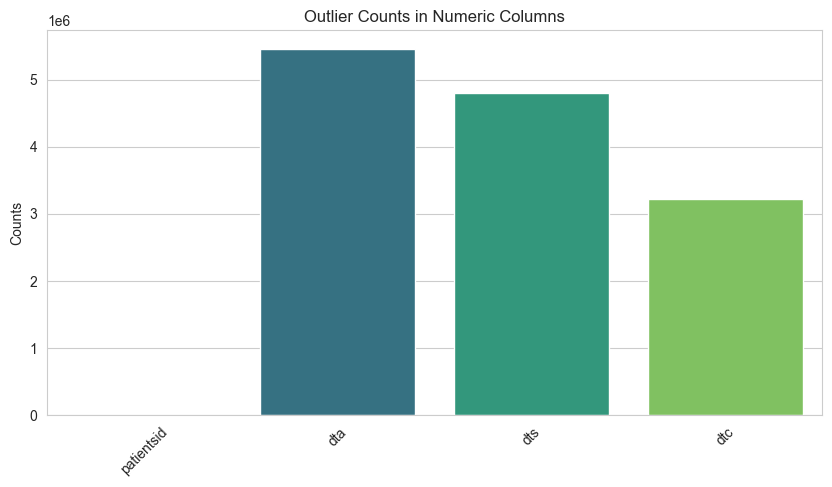

In [7]:
visualize_outliers(data)

Traitement des outliers

In [8]:
# Find and display rows where 'dts' is greater than 'dtc'
len_out_dtc = len(data[data['dts'] > data['dtc']])
print("Number of Rows where 'dts' is greater than 'dtc':", len_out_dtc)

Number of Rows where 'dts' is greater than 'dtc': 2880010


In [9]:
# Filter the data to remove rows where 'dts' is greater than 'dtc'
data = data[data['dts'] < data['dtc']]

# Display new data shape after removing erroneous entries
print("New data shape after outlier removal:", data.shape)


New data shape after outlier removal: (45723552, 11)


In [10]:
remove_outliers_from_dataframe(data)

Data shape after outlier removal: (36688080, 11)
Total outliers removed: 9035472


9035472

In [11]:
data.shape

(36688080, 11)

#### Outlier Detection in Categorical Variables
For categorical variables, We assume that any anomalies or irregular entries were controlled during data entry, often through enforced choices like dropdown menus or checklists.


3.1.3 - Duplicated Values <a name="3.1.3"></a>

In [12]:
print(data.shape)

(36688080, 11)


In [13]:
initial_count = len(data)
data.drop_duplicates(inplace=True)
duplicates_removed = initial_count - len(data)
print(f'Number of deleted duplicates: {duplicates_removed}')

Number of deleted duplicates: 134


In [14]:
print(data.shape)

(36687946, 11)


3.2 - Data Transformation<a id="3.2"></a>

In [15]:
data.head()

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,dtc,non_va,zip,state,disp
1,9204541,2017-02-01 10:20:10,573,403,0.0,30.0,64.0,0,315,GEORGIA,COMPLETE/UPDATE
4,9204541,2019-02-08 12:41:00,573,409,0.0,28.0,44.0,0,315,GEORGIA,COMPLETE/UPDATE
6,9204541,2020-06-29 12:56:56,573,502,4.0,1.0,9.0,1,315,GEORGIA,COMPLETE/UPDATE
7,9204546,2017-10-11 10:42:46,573,142,0.0,4.0,68.0,0,461,INDIANA,COMPLETE/UPDATE
10,9204549,2022-11-15 10:08:28,573,205,0.0,3.0,53.0,0,322,FLORIDA,COMPLETE/UPDATE


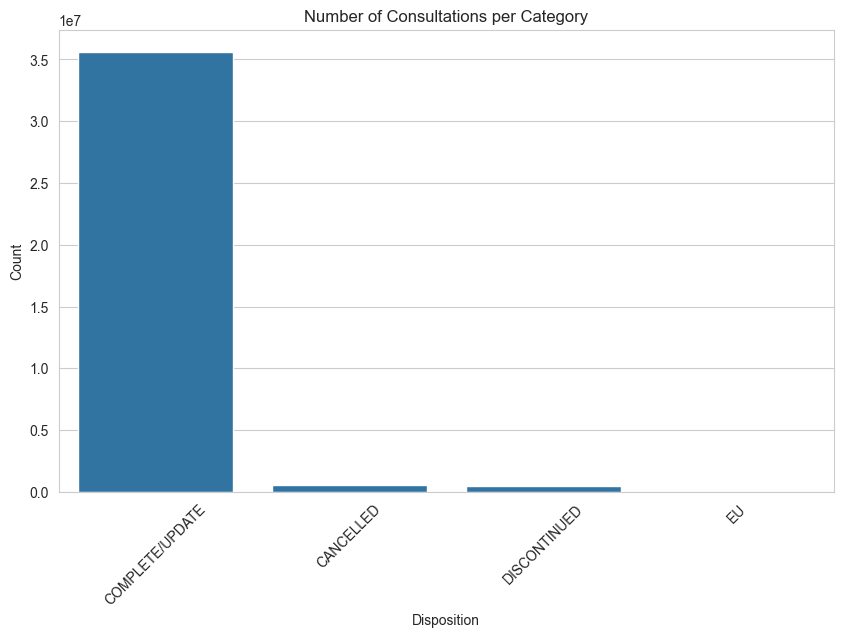

In [16]:
# Plotting the number of consultations per category
plot_consultation_counts(data)

In [17]:
# Filtering data for categories ['COMPLETE/UPDATE'] in disp et delelete the column 
data = filter_categories(data, ['COMPLETE/UPDATE'])
data.drop('disp', axis=1, inplace=True)
data.head()

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,dtc,non_va,zip,state
1,9204541,2017-02-01 10:20:10,573,403,0.0,30.0,64.0,0,315,GEORGIA
4,9204541,2019-02-08 12:41:00,573,409,0.0,28.0,44.0,0,315,GEORGIA
6,9204541,2020-06-29 12:56:56,573,502,4.0,1.0,9.0,1,315,GEORGIA
7,9204546,2017-10-11 10:42:46,573,142,0.0,4.0,68.0,0,461,INDIANA
10,9204549,2022-11-15 10:08:28,573,205,0.0,3.0,53.0,0,322,FLORIDA


3.2.1 - Feature engeneering <a id="3.2.1"></a>

In [18]:
# Add the new column 'ts' by subtracting 'dts' from 'dtc'
data['ts'] = data['dtc'] - data['dts']
# drop the corresponding columns
data.drop(['dtc', 'dts'], axis=1, inplace=True)

print("Data after dropping 'dtc' and 'dts':")

data.head()

Data after dropping 'dtc' and 'dts':


,patientsid,activitydatetime,sta3n,stopcode,dta,non_va,zip,state,ts
1,9204541,2017-02-01 10:20:10,573,403,0.0,0,315,GEORGIA,34.0
4,9204541,2019-02-08 12:41:00,573,409,0.0,0,315,GEORGIA,16.0
6,9204541,2020-06-29 12:56:56,573,502,4.0,1,315,GEORGIA,8.0
7,9204546,2017-10-11 10:42:46,573,142,0.0,0,461,INDIANA,64.0
10,9204549,2022-11-15 10:08:28,573,205,0.0,0,322,FLORIDA,50.0


In [19]:
remove_outliers_from_column(data, "ts")

Data shape after outlier removal in column ts: (34038105, 9)
Total outliers removed from column ts: 1578196


1578196

In [20]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34038105 entries, 1 to 51874102
Data columns (total 9 columns):
 #   Column            Dtype   
---  ------            -----   
 0   patientsid        uint32  
 1   activitydatetime  object  
 2   sta3n             category
 3   stopcode          category
 4   dta               float32 
 5   non_va            category
 6   zip               category
 7   state             category
 8   ts                float32 
dtypes: category(5), float32(2), object(1), uint32(1)
memory usage: 3.3 GB


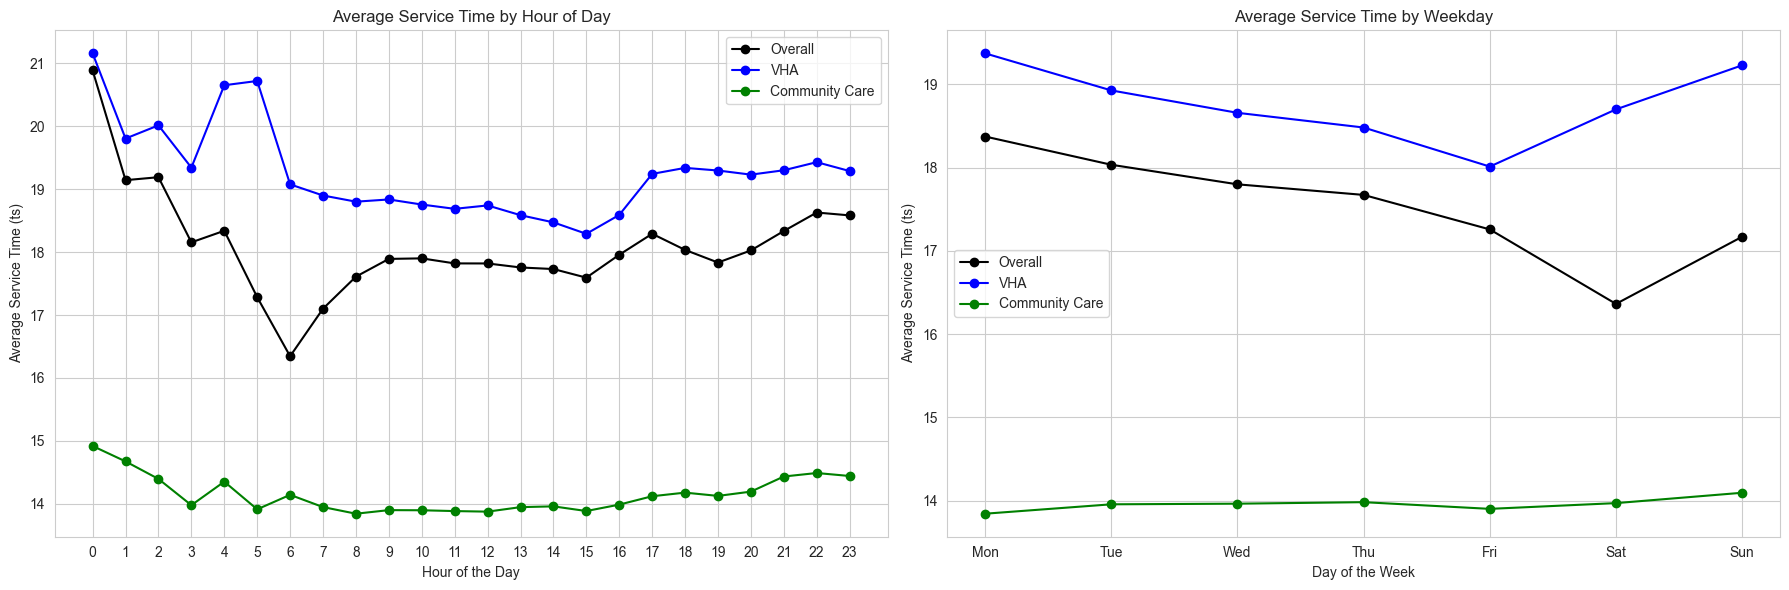

In [17]:
plot_service_time_by_hour_and_weekday(data)

In [21]:
# Convert the datetime column to datetime type if not already
data['activitydatetime'] = pd.to_datetime(data['activitydatetime'])
# Sort the DataFrame by the datetime column
data.sort_values(by='activitydatetime', inplace=True)

In [22]:
# Add temporal features
data['day_of_week'] = data['activitydatetime'].dt.dayofweek
data['day_of_month'] = data['activitydatetime'].dt.day
data['month'] = data['activitydatetime'].dt.month
data['hour'] = data['activitydatetime'].dt.hour

In [23]:
data.drop('activitydatetime', axis=1, inplace=True)

In [24]:
data = encode_categorical_columns(data)

In [25]:
data.head(3)

,patientsid,sta3n,stopcode,dta,zip,state,ts,day_of_week,day_of_month,month,hour,non_va_0,non_va_1
0,25556699,14,118,0.0,454,29,22.0,3,2,1,11,1.0,0.0
1,23645357,1,179,0.0,37,25,27.0,3,2,1,14,1.0,0.0
2,26976468,112,140,0.0,723,54,25.0,3,2,1,14,1.0,0.0


3.2.2 - Data Standardization<a name="3.2.2"></a>

In [27]:
data, scaler = standardize_numeric_columns(data,exclude_column='patientsid')

In [28]:
data.head(3)

,patientsid,sta3n,stopcode,dta,zip,state,ts,day_of_week,day_of_month,month,hour,non_va_0,non_va_1
0,25556699,-1.508860,-0.143277,-0.731609,-0.123022,-0.133862,0.300321,0.607847,-1.568841,-1.605999,-0.383440,0.483622,-0.483622
1,23645357,-1.871247,0.687390,-0.731609,-1.785913,-0.351893,0.657150,0.607847,-1.568841,-1.605999,0.555851,0.483622,-0.483622
2,26976468,1.222985,0.156307,-0.731609,0.949683,1.228832,0.514418,0.607847,-1.568841,-1.605999,0.555851,0.483622,-0.483622


In [29]:
split_ratio=0.7
split_point = int(len(data) * split_ratio)
training_set = data[:split_point]
test_set = data[split_point:]

In [30]:
import gc 
# Pour des soucis de mémoire, on libère la variable data
del data
gc.collect()  # vider le garbage collector Explicitly

250

In [31]:
training_set.head(3)

,patientsid,sta3n,stopcode,dta,zip,state,ts,day_of_week,day_of_month,month,hour,non_va_0,non_va_1
0,25556699,-1.508860,-0.143277,-0.731609,-0.123022,-0.133862,0.300321,0.607847,-1.568841,-1.605999,-0.383440,0.483622,-0.483622
1,23645357,-1.871247,0.687390,-0.731609,-1.785913,-0.351893,0.657150,0.607847,-1.568841,-1.605999,0.555851,0.483622,-0.483622
2,26976468,1.222985,0.156307,-0.731609,0.949683,1.228832,0.514418,0.607847,-1.568841,-1.605999,0.555851,0.483622,-0.483622


In [32]:
test_set.head(3)

,patientsid,sta3n,stopcode,dta,zip,state,ts,day_of_week,day_of_month,month,hour,non_va_0,non_va_1
23826673,24175602,-0.700457,-1.682055,0.042902,-0.115046,-0.133862,-0.698800,1.287496,-1.340415,-0.117664,-0.696537,0.483622,-0.483622
23826674,807125116,0.163698,0.782712,0.042902,-0.860755,0.465723,-1.198360,1.287496,-1.340415,-0.117664,-0.696537,-2.067731,2.067731
23826675,1210079468,0.581838,0.796330,0.042902,-0.852780,0.465723,1.513539,1.287496,-1.340415,-0.117664,-0.696537,0.483622,-0.483622


In [33]:
test_set.tail(3)

,patientsid,sta3n,stopcode,dta,zip,state,ts,day_of_week,day_of_month,month,hour,non_va_0,non_va_1
34038102,1604874328,1.473869,-0.606272,0.042902,-0.948486,1.610387,1.584905,-0.071802,1.629117,0.47767,3.373724,0.483622,-0.483622
34038103,1202520586,0.999977,-1.042032,-0.731609,-0.912596,0.465723,1.013979,-0.071802,1.629117,0.47767,3.373724,0.483622,-0.483622
34038104,17862814,0.804846,0.060985,-0.731609,-1.048180,1.501371,-0.841531,-0.071802,1.629117,0.47767,3.373724,0.483622,-0.483622


<a name="4"></a>
## 4 - Modeling

<a name="4.1"></a>
### 4.1 - Serie Temporelle 

hypothèses : 
-  $y_{t+1} = f(y_t, y_{t-1}, \ldots)$, avec y : time service et t:date_activitity et y depends on X(features)
-  Complexes and Non linear relationships between y and X (features)


<a name="4.1.1"></a>
###  4.1.1 - LSTM

In [34]:
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


In [35]:
# Extracting features and target ('ts')
X_train = training_set.drop(['patientsid', 'ts'], axis=1).values
y_train = training_set['ts'].values

# Now delete train_data
del training_set
gc.collect()  # Explicitly call the garbage collector

0

In [36]:
X_test = test_set.drop(['patientsid', 'ts'], axis=1).values
y_test = test_set['ts'].values

In [37]:
# Now delete train_data and test_data
del test_set
gc.collect()  # Explicitly call the garbage collector

0

In [38]:
X_train[:3]

array([[-1.50885982, -0.14327748, -0.7316085 , -0.12302161, -0.1338623 ,
         0.6078469 , -1.56884051, -1.60599887, -0.38343959,  0.48362192,
        -0.48362192],
       [-1.87124742,  0.68738991, -0.7316085 , -1.78591342, -0.35189345,
         0.6078469 , -1.56884051, -1.60599887,  0.55585123,  0.48362192,
        -0.48362192],
       [ 1.22298516,  0.15630748, -0.7316085 ,  0.94968317,  1.22883245,
         0.6078469 , -1.56884051, -1.60599887,  0.55585123,  0.48362192,
        -0.48362192]])

In [39]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [40]:
model = Sequential([
    LSTM(150, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),  
    LSTM(100, return_sequences=False),  
    Dropout(0.1),
    Dense(100, activation='relu'),  
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dense(1) 
])


In [ ]:
model.summary()

In [41]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

In [42]:
# Optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='mean_squared_error')

In [43]:
# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, verbose=1)

# Fit model 
history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_test, y_test), verbose=2,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/50
372292/372292 - 2887s - 8ms/step - loss: 0.9452 - val_loss: 1.0243 - learning_rate: 0.0100
Epoch 2/50
372292/372292 - 2723s - 7ms/step - loss: 0.9437 - val_loss: 1.0267 - learning_rate: 0.0100
Epoch 3/50
372292/372292 - 2729s - 7ms/step - loss: 0.9431 - val_loss: 1.0228 - learning_rate: 0.0100
Epoch 4/50
372292/372292 - 2537s - 7ms/step - loss: 0.9426 - val_loss: 1.0286 - learning_rate: 0.0100
Epoch 5/50
372292/372292 - 2532s - 7ms/step - loss: 0.9411 - val_loss: 1.0195 - learning_rate: 0.0100
Epoch 6/50
372292/372292 - 2528s - 7ms/step - loss: 0.9401 - val_loss: 1.0231 - learning_rate: 0.0100
Epoch 7/50
372292/372292 - 2465s - 7ms/step - loss: 0.9388 - val_loss: 1.0272 - learning_rate: 0.0100
Epoch 8/50

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
372292/372292 - 2452s - 7ms/step - loss: 0.9377 - val_loss: 1.0202 - learning_rate: 0.0100
Epoch 9/50
372292/372292 - 2509s - 7ms/step - loss: 0.9323 - val_loss: 1.0164 - learning_rate: 1.0000e-03
E

KeyboardInterrupt: 

In [ ]:
# we save model 
model.save('modele_lstm_v1.keras')  
print("Modèle enregistré avec succès.")

In [43]:
# Charge le modèle
#model = load_model('modele_lstm_v1.keras')
print("Modèle chargé avec succès.")

ValueError: File not found: filepath=modele_lstm_v1.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)

# The training history for loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [ ]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics for training
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

# Calculate metrics for testing
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

# Print results
print("Training Metrics:")
print(f"MSE: {mse_train}, MAE: {mae_train}, RMSE: {rmse_train}, R²: {r2_train}")
print("Testing Metrics:")
print(f"MSE: {mse_test}, MAE: {mae_test}, RMSE: {rmse_test}, R²: {r2_test}")


In [ ]:
def plot_predictions(y_train, y_pred_train, y_test, y_pred_test, scaler):
    """
    Plots the actual vs. predicted values for both training and testing datasets.
    
    Args:
    y_train (array-like): Actual target values for the training set.
    y_pred_train (array-like): Predicted target values for the training set.
    y_test (array-like): Actual target values for the test set.
    y_pred_test (array-like): Predicted target values for the test set.
    scaler (StandardScaler): The scaler instance used to normalize the data.
    """
    # Inverse transform the scaled data
    y_train_real = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_pred_train_real = scaler.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
    y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_test_real = scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

    # Plotting
    plt.figure(figsize=(14, 7))

    # Training data plot
    plt.subplot(1, 2, 1)
    plt.plot(y_train_real, label='Actual Training Data', color='blue')
    plt.plot(y_pred_train_real, label='Predicted Training Data', color='red', linestyle='--')
    plt.title('Comparison of Actual and Predicted - Training Set')
    plt.xlabel('Sample Index')
    plt.ylabel('Service Time')
    plt.legend()

    # Test data plot
    plt.subplot(1, 2, 2)
    plt.plot(y_test_real, label='Actual Test Data', color='blue')
    plt.plot(y_pred_test_real, label='Predicted Test Data', color='red', linestyle='--')
    plt.title('Comparison of Actual and Predicted - Test Set')
    plt.xlabel('Sample Index')
    plt.ylabel('Service Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
plot_predictions(y_train, y_pred_train, y_test, y_pred_test, scaler)

<a name="4.1.2"></a>
### 4.1.2 - SARIMA

In [26]:
data = prepare_data(data)  
training_set, test_set = split_data(data) 